# Zyfra

¿Cómo se extrae el oro del mineral? Veamos las etapas de este proceso.
El mineral extraído se somete a un tratamiento primario para obtener la mezcla de mineral, o alimentación rougher, que es la materia prima utilizada para la flotación (también conocida como proceso rougher). Después de la flotación, el material se somete al proceso de purificación en dos etapas.

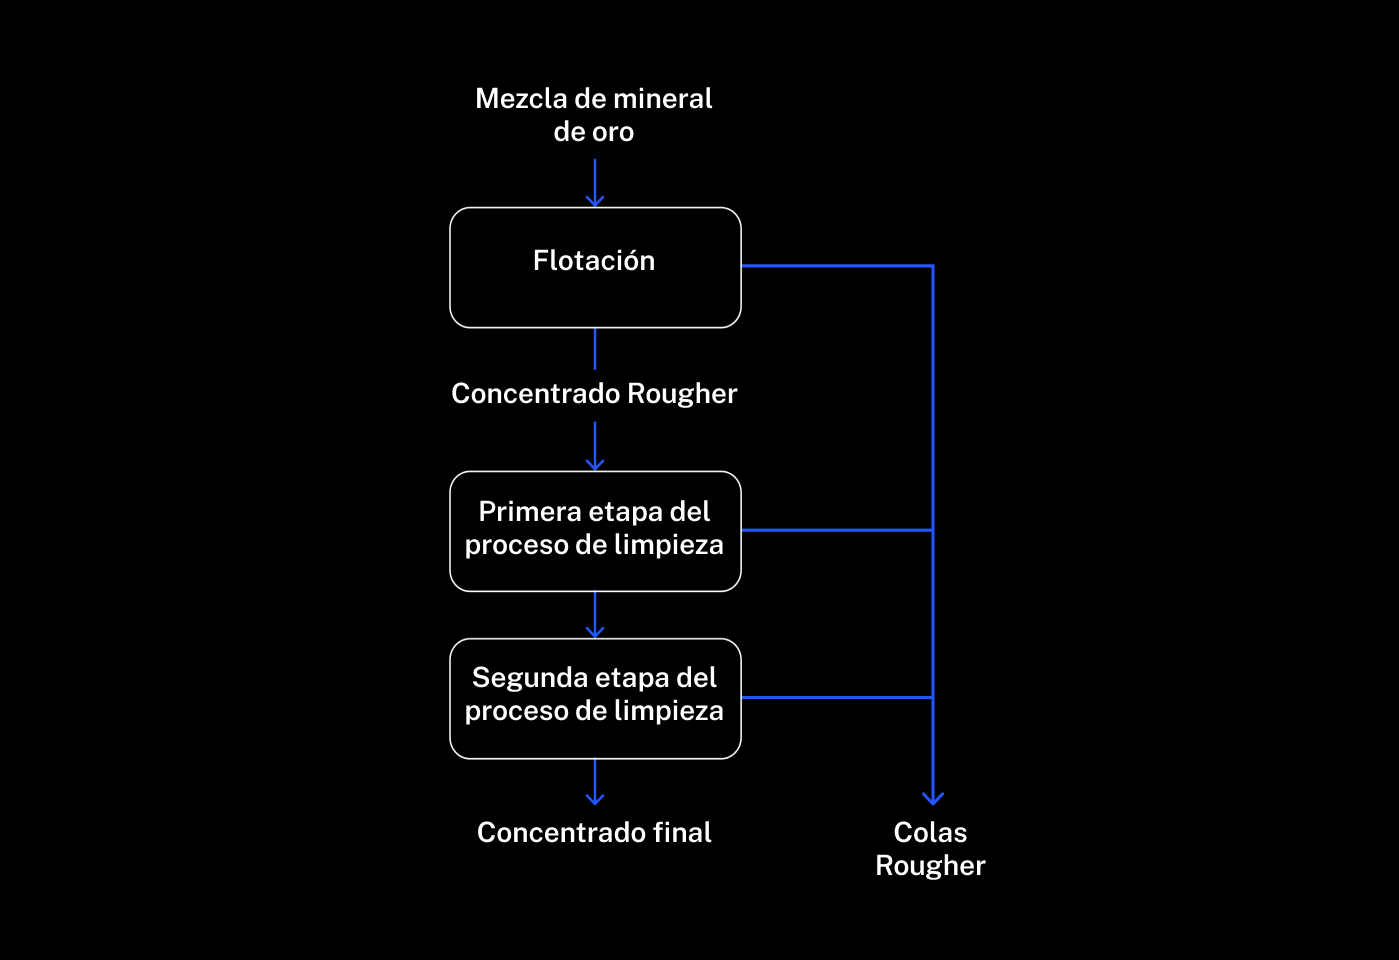

Veamos el proceso paso a paso:

1. Flotación

La mezcla de mineral de oro se introduce en las plantas de flotación para obtener un concentrado de oro rougher y colas rougher (es decir, residuos del producto con una baja concentración de metales valiosos).

La estabilidad de este proceso se ve afectada por la volatilidad y el estado físico-químico desfavorable de la pulpa de flotación (una mezcla de partículas sólidas y líquido).

2. Purificación

El concentrado rougher se somete a dos etapas de purificación. Tras esto, tenemos el concentrado final y las nuevas colas.

Descripción de datos
Proceso tecnológico

Rougher feed: materia prima
Rougher additions (o adiciones de reactivos): reactivos de flotación: xantato, sulfato, depresante
Xantato: promotor o activador de la flotación
Sulfato: sulfuro de sodio para este proceso en particular
Depresante: silicato de sodio
Rougher process: flotación
Rougher tails: residuos del producto
Float banks: instalación de flotación
Cleaner process: purificación
Rougher Au: concentrado de oro rougher
Final Au: concentrado de oro final
Parámetros de las etapas

air amount: volumen de aire
fluid levels
feed size: tamaño de las partículas de la alimentación
feed rate
Denominación de las características
Así es como se denominan las características:

[stage].[parameter_type].[parameter_name]

Ejemplo: rougher.input.feed_ag

Valores posibles para [stage]:

rougher: flotación
primary_cleaner: purificación primaria
secondary_cleaner: purificación secundaria
final: características finales
Valores posibles para [parameter_type]:

input: parámetros de la materia prima
output: parámetros del producto
state: parámetros que caracterizan el estado actual de la etapa
calculation: características de cálculo

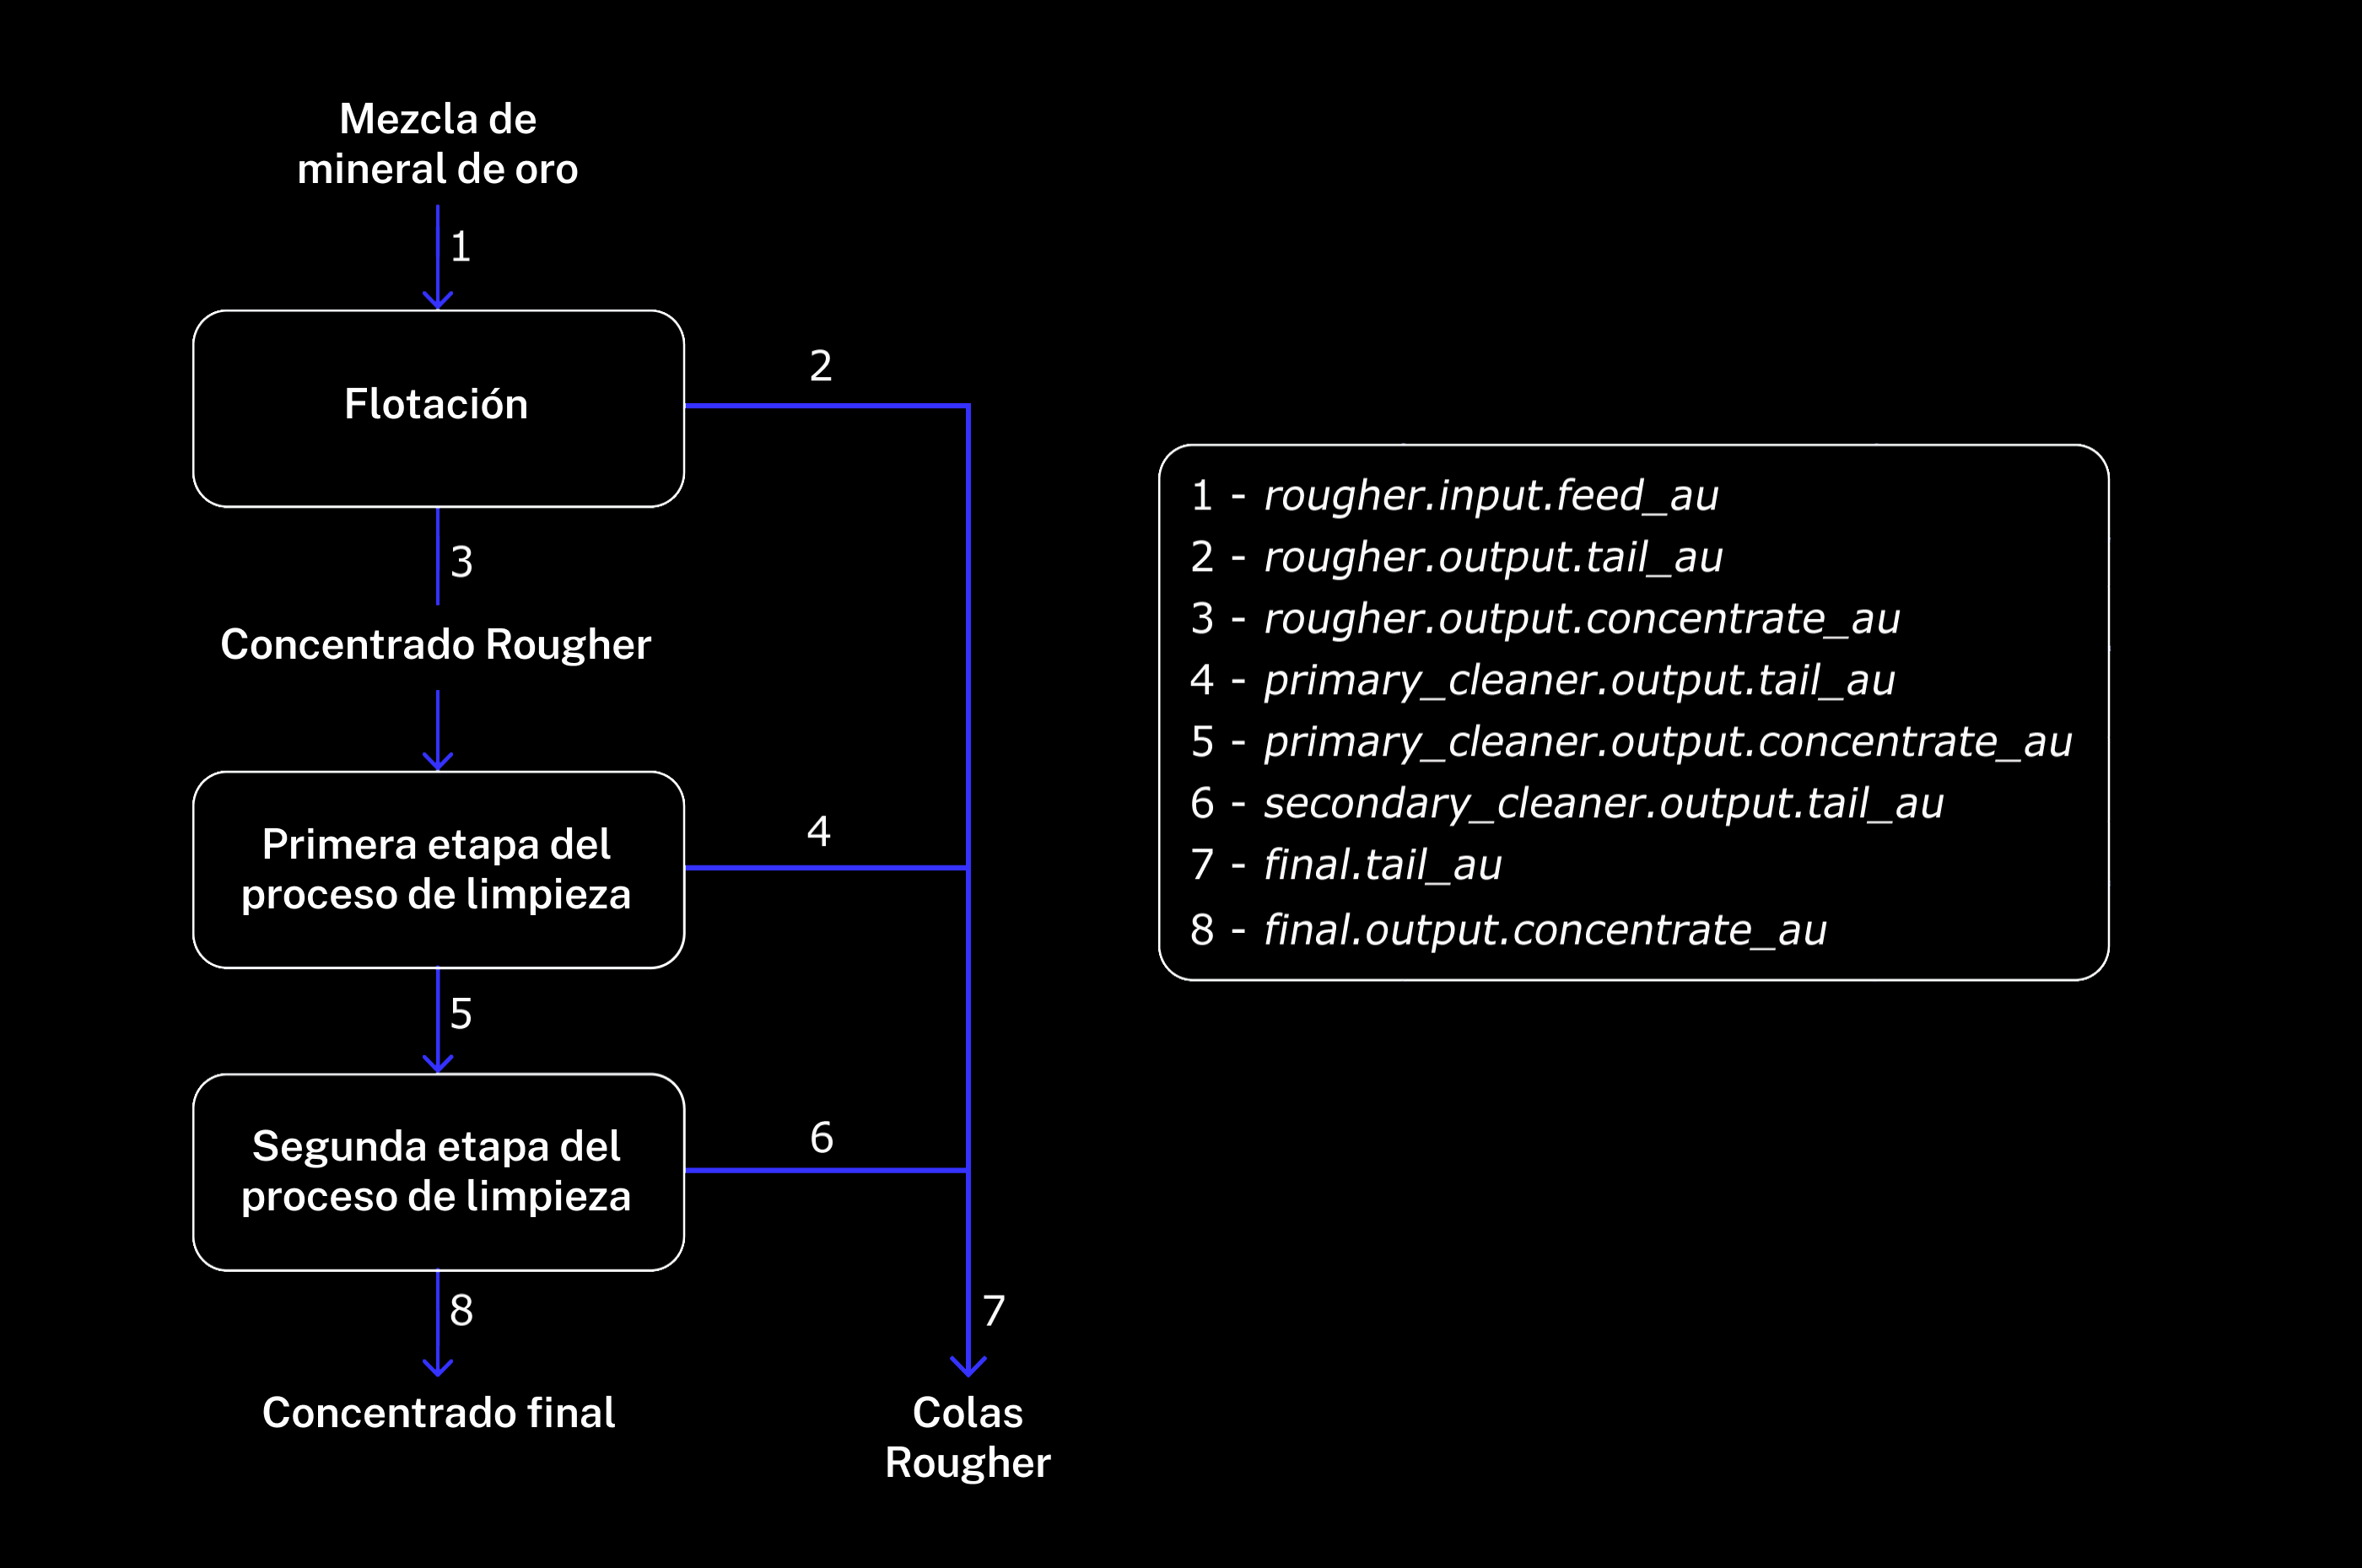

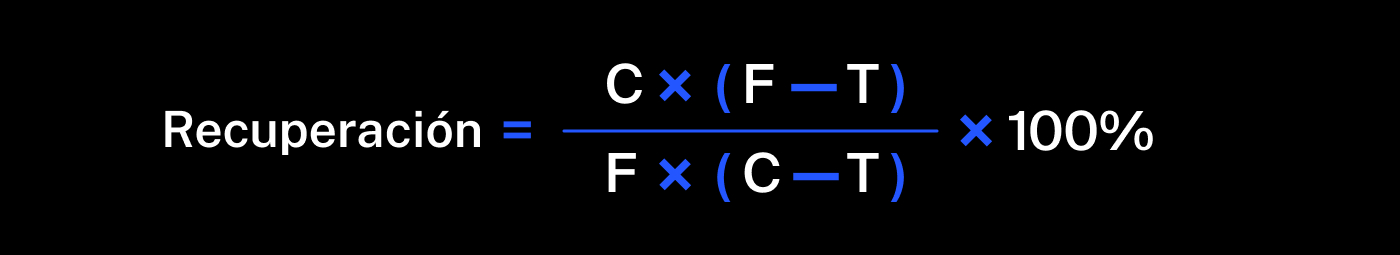

Donde:

C:

- Para saber la recuperación del concentrado rougher → la proporción de oro en el concentrado justo después de la flotación o
- Para saber la recuperación del concentrado final → la proporción de oro después de la purificación.

F:

- Para saber la recuperación del concentrado rougher → la proporción de oro en la alimentación antes de la flotación
- Para saber la recuperación del concentrado final → la proporción de oro en el concentrado justo después de la flotación.

T:

- Para saber la recuperación del concentrado rougher → la proporción de oro en las colas rougher justo después de la flotación.
- Para saber la recuperación del concentrado final → la proporción de oro después de la purificación.

## Métricas de evaluación

Para resolver el problema, necesitaremos una nueva métrica. Se llama sMAPE, o error medio absoluto porcentual simétrico.

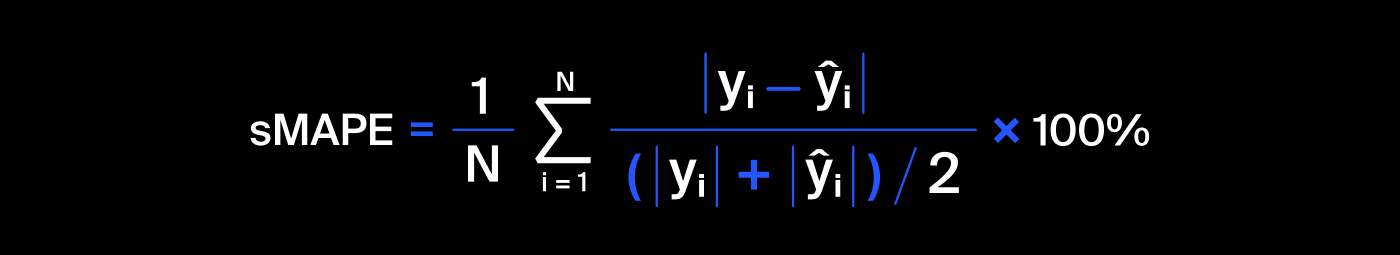

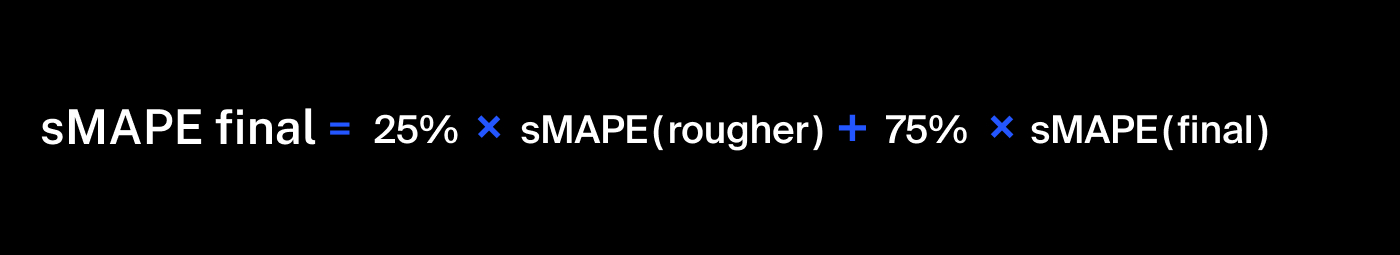

## Objetivo

Crear un modelo para predecir la cantidad de oro extraído del mineral de oro.

## 1. Preparar datos

In [37]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

### 1.1 Cargar datos

In [2]:
train = pd.read_csv('/datasets/gold_recovery_train.csv')
test = pd.read_csv('/datasets/gold_recovery_test.csv')
df = pd.read_csv('/datasets/gold_recovery_full.csv')

print(df.info())
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


Es posible observar que los tres dataframes contienen valores ausentes en distintas columnas. Por otra parte, se identificaron menos columnas en el dataframe correspondiente al conjunto de test.

### 1.2 Cálculo de la recuperación

In [3]:
#Calcular recuperación
C = train['rougher.output.concentrate_au']
F = train['rougher.input.feed_au']
T = train['rougher.output.tail_au']

recovery_calculated = ((C * (F - T)) / (F * (C - T))) * 100
recovery_real = train['rougher.output.recovery']

#Calcular MAE
#MAE = mean_absolute_error(recovery_real, recovery_calculated)
MAE = np.mean(np.abs(recovery_real - recovery_calculated))

print('Error absoluto medio (MAE): ', MAE)

Error absoluto medio (MAE):  9.303415616264301e-15


Se observa que el error absoluto medio es muy pequeño, evidenciando que el cálculo de la recuperación es correcto, no existen diferencias significativas en los datos calculados y los presentados. No se utilizó el MAE de Sklearn por la existencia de valores nulos que serán tratados en el apartado de preprocesamiento de datos.

### 1.3 características no disponibles en el conjunto de prueba

In [4]:
train_cols = list(train.columns)
test_cols = list(test.columns)

missing_cols = []

for col in train_cols:
    if col not in test_cols:
        missing_cols.append(col)

missing_info = train[missing_cols]

print('Columnas que no están en test:')
print(missing_info.info())
#print('\n'.join(missing_cols))

Columnas que no están en test:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_pb                         16788 non-null  float64
 2   final.output.concentrate_sol                        16490 non-null  float64
 3   final.output.concentrate_au                         16789 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_pb                                16677 non-null  float64
 7   final.output.tail_sol                               16715 non-null  float64
 8   final.output.tail_au                         

Los parámetros de las columnas que no aparecen en test son principalmente del tipo output y calculation, esto no tendría mucho sentido al momento de realizar el modelo ya que no existirían las columnas objetivo. Todas las columnas son de tipo float.

### 1.4 Preprocesamiento de datos

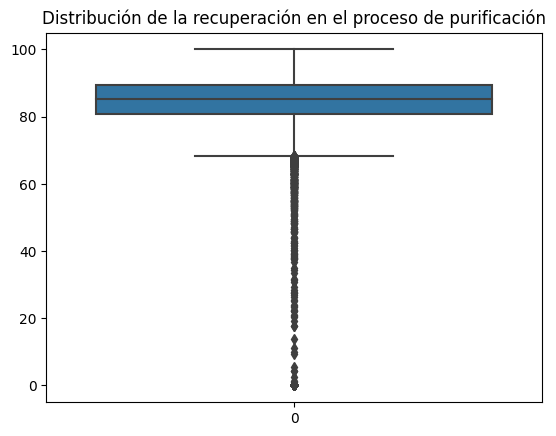

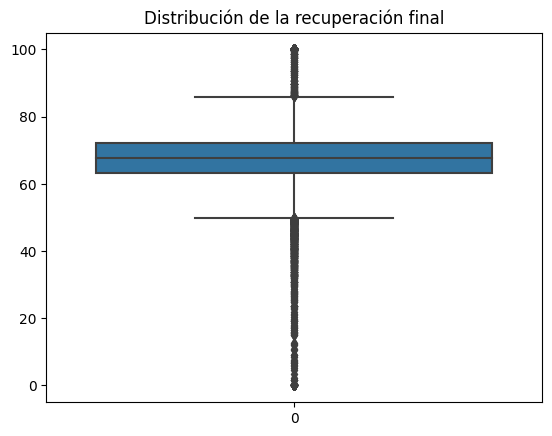

In [5]:
# Tratamiento de valores ausentes
train['rougher.output.recovery'] = train['rougher.output.recovery'].dropna()
train['final.output.recovery'] = train['final.output.recovery'].dropna()

train = train.fillna(train.median())
test = test.fillna(test.median())

#Cambiar tipos de datos
train['date'] = pd.to_datetime(train['date'])
train['date'] = pd.to_datetime(train['date'])

#Verificar la existencia de valores atípicos
sns.boxplot(data=train['rougher.output.recovery'])
plt.title('Distribución de la recuperación en el proceso de purificación')
plt.show()

sns.boxplot(data=train['final.output.recovery'])
plt.title('Distribución de la recuperación final')
plt.show()


In [6]:
#Eliminar valores atípicos
train = train[((train['rougher.output.recovery'] >= 60) & (train['rougher.output.recovery'] <= 100)) & ((train['final.output.recovery'] >= 40) & (train['final.output.recovery'] <=100))]


En el preprocesamiento de datos se eliminaron los datos nulos de las columnas objetivo ('rougher.output.recovery' y 'final.output.recovery') y se completaron los valores ausentes con la mediana en las demás características. Se empleó la mediana porque es una medida que se ve menos afectada por el sesgo de valores atípicos. Por otra parte, se filtraron valores atípicos en las columnas objetivo encontrados con boxplots. 

## 2. Analisis de datos

### 2.1 Cómo cambia la concentración de metales (Au, Ag, Pb) en función de la etapa de purificación

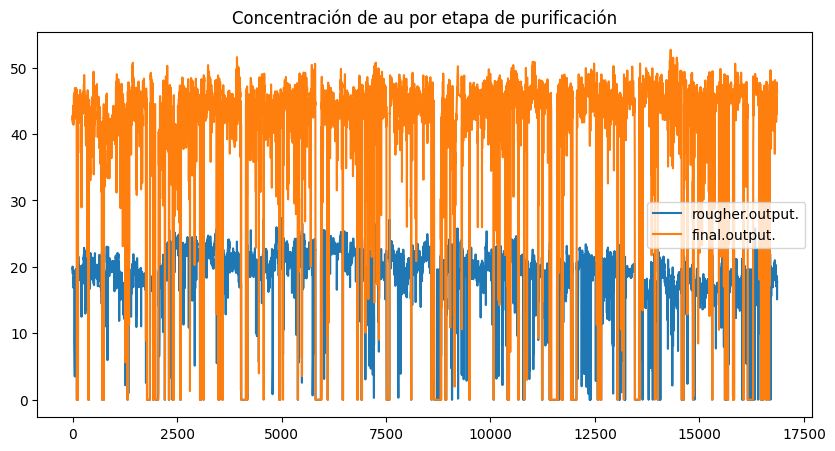

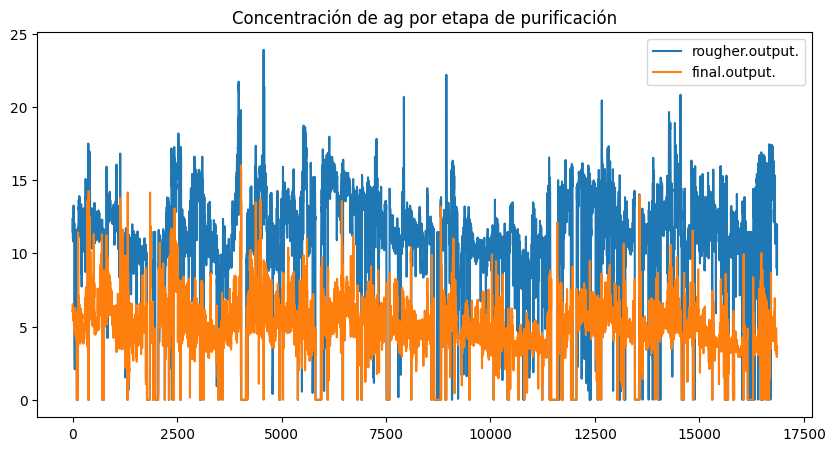

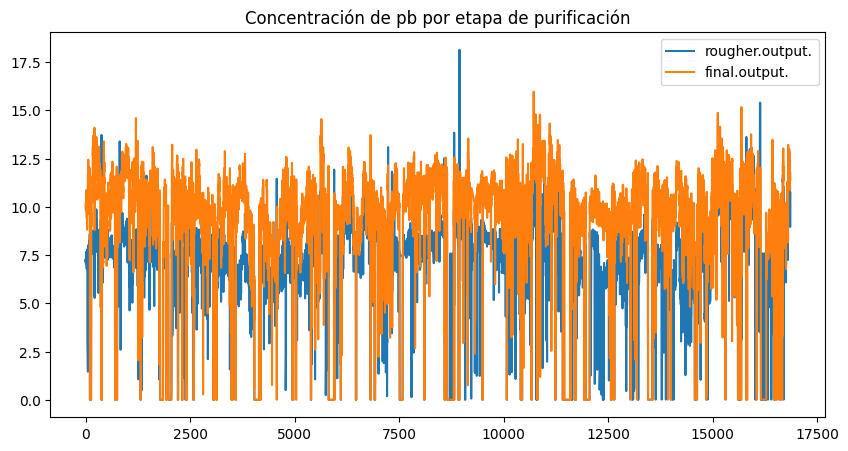

In [7]:
metales = ['au', 'ag', 'pb']
etapas = ['rougher.output.', 'final.output.']

for metal in metales:
    plt.figure(figsize=(10, 5))
    for etapa in etapas:
        column = etapa + 'concentrate_' + metal
        if column in train.columns:  
            plt.plot(train[column], label=etapa)
    plt.title(f"Concentración de {metal} por etapa de purificación")
    plt.legend()
    plt.show()

        
        
        

Se observa que la concentración de oro en la etapa intermedia de purificación (rougher)  oscila entre un 20 y 25%, en cambio en la etapa final la concentración alcanza un 50% con algunas caidas considerables. En el caso de la plata se ve un comportamiento contrario, obteniendo mayor concentración en la etapa intermedia de purificación del metal. Por último la concentración para el plomo en la etapa final es mayor que en la intermedia a pesar de que se obtiene una media de 10 a 12% no mucho mayor al 8% alcanzado en la etapa intermedia. Para el plomo, se observan mayores valores atípicos de concentración.

### 2.2 Compara las distribuciones del tamaño de las partículas de la alimentación en el conjunto de entrenamiento y en el conjunto de prueba.

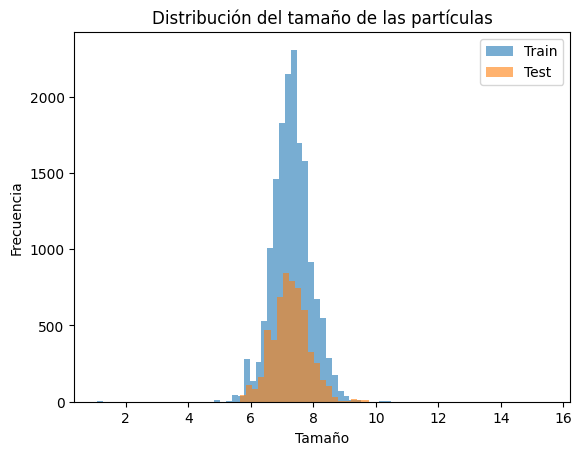

Media tamaño de partículas train: 7.302607290580017
Media tamaño de partículas test: 7.2646512922454205
Desviación estándar tamaño de partículas train: 0.6175039011749794
Desviación tamaño de partículas test: 0.6115257797788536


In [8]:
train_size = train['primary_cleaner.input.feed_size']
test_size = test['primary_cleaner.input.feed_size']

plt.hist(train_size, bins=50, alpha=0.6, label='Train')
plt.hist(test_size, bins=50, alpha=0.6, label='Test')
plt.title('Distribución del tamaño de las partículas')
plt.xlabel('Tamaño')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

print("Media tamaño de partículas train:", train_size.mean())
print("Media tamaño de partículas test:", test_size.mean())
print("Desviación estándar tamaño de partículas train:", train_size.std())
print("Desviación tamaño de partículas test:", test_size.std())

Se observa que la distribución del tamaño de las partículas en los conjuntos train y test es similar, con una media y una desviación estandar parecidas. 

### 2.3 ¿Observas algún valor anormal en la distribución total? Si es así, ¿merece la pena eliminar esos valores de ambas muestras? 

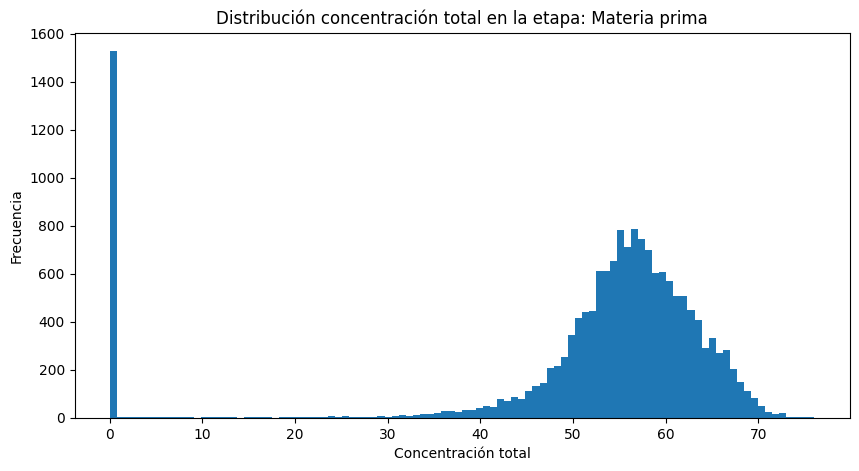

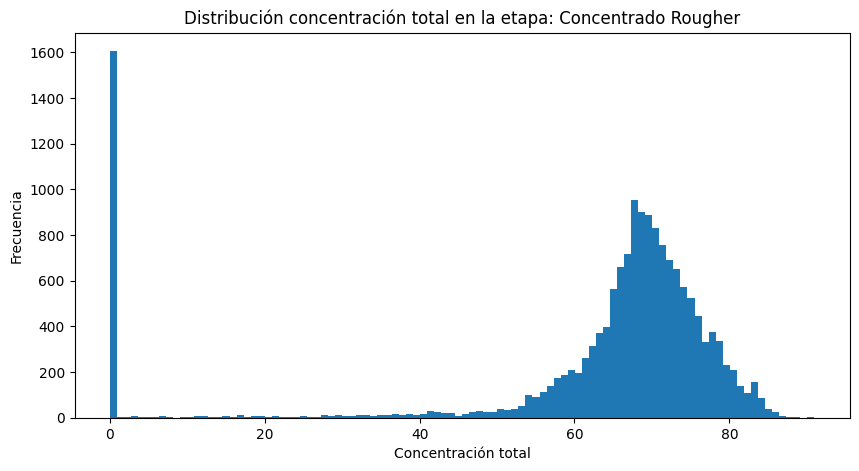

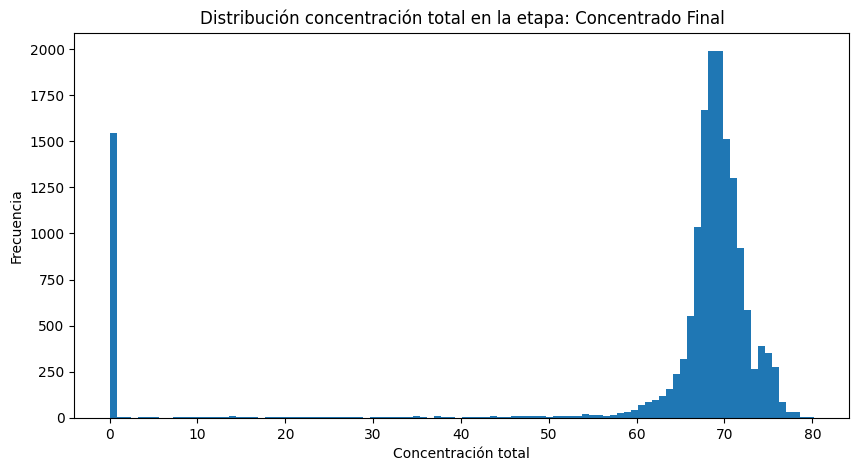

In [9]:
#Concentraciones totales (todos los metales) por etapa
materia_prima_cols = [col for col in train.columns if 'rougher.input.feed_' in col and col != 'rougher.input.feed_rate' and col != 'rougher.input.feed_size']
materia_prima = train[materia_prima_cols]
rougher = 'rougher.output.concentrate_'
final = 'final.output.concentrate_'

input_total = materia_prima.sum(axis=1)
rougher_total = train.filter(like=rougher, axis=1).sum(axis=1)
final_total = train.filter(like=final, axis=1).sum(axis=1)

etapas = {'Materia prima': input_total,
    'Concentrado Rougher': rougher_total,
    'Concentrado Final': final_total}

#Histogramas
for nombre, etapa in etapas.items():
    plt.figure(figsize=(10, 5))
    plt.hist(etapa, bins=100)
    plt.title(f"Distribución concentración total en la etapa: {nombre}")
    plt.xlabel('Concentración total')
    plt.ylabel('Frecuencia')
    plt.show()

Se observa en las tres etapas un valor atípico de concentración 0 con gran frecuencia, este valor atípico debe eliminarse porque la concentración nunca debería ser cero a menos que no exista ningún material para la purificación.

In [10]:
#Eliminar valores atípicos en las concentraciones
input_total_cleaned = input_total > 0
rougher_total_cleaned = rougher_total > 0
final_total_cleaned = final_total > 0

cleaned_total = input_total_cleaned & rougher_total_cleaned & final_total_cleaned
train_cleaned = train[cleaned_total]

## 3. Construir el modelo

### 3.1 Escribe una función para calcular el valor final de sMAPE.

In [11]:
def smape(y_real, y_pred):
    numerator = np.abs(y_real - y_pred)
    denominator = (np.abs(y_real) + np.abs(y_pred))/2
    smape = np.mean(numerator/denominator)*100
    return smape

def final_smape(y_rougher_real, y_rougher_pred, y_final_real, y_final_pred):
    smape_final = 0.25 * smape(y_rougher_real, y_rougher_pred) + 0.75 * smape(y_final_real, y_final_pred)
    return smape_final
    

### 3.2 Entrena diferentes modelos. Evalúalos aplicando la validación cruzada. Elige el mejor modelo y pruébalo utilizando la muestra de prueba.

In [ ]:
# Definir las columnas objetivo y las características
targets = ['rougher.output.recovery', 'final.output.recovery']
features = train_cleaned.drop(targets + ['date'], axis=1)
target_rougher = train_cleaned['rougher.output.recovery']
target_final = train_cleaned['final.output.recovery']

#Dividir en subconjuntos de train y valid
features_train, features_valid, rougher_train, rougher_valid, final_train, final_valid = train_test_split(features, target_rougher, target_final, test_size = 0.25, random_state = 12345)

#### RandomForest

In [29]:
#KFold
cv = KFold(n_splits=3, shuffle=True, random_state=12345)

#Entrenar un modelo RandomForest
##GridSearchCV 
param_grid_rf = {
    'n_estimators': [20,80],
    'max_depth': [5,8]
}

rf = RandomForestRegressor(random_state=12345)

##Rougher
grid_rf_rougher = GridSearchCV(
    rf,
    param_grid_rf,
    scoring='neg_mean_absolute_error',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid_rf_rougher.fit(features_train, rougher_train)
rougher_rf_pred = grid_rf_rougher.predict(features_valid)
print("Mejores parámetros RF rougher:", grid_rf_rougher.best_params_)
mae_rf_rougher = mean_absolute_error(rougher_valid, rougher_rf_pred)
print('MAE RandomForest rougher:', mae_rf_rougher)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Mejores parámetros RF rougher: {'max_depth': 8, 'n_estimators': 80}
RandomForest MAE rougher: 0.9070581297606204


In [30]:
##RandomForest
###Final
grid_rf_final = GridSearchCV(
    rf,
    param_grid_rf,
    scoring='neg_mean_absolute_error',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid_rf_final.fit(features_train, final_train)
final_rf_pred = grid_rf_final.predict(features_valid)
print("Mejores parámetros RF final:", grid_rf_final.best_params_)
mae_rf_final = mean_absolute_error(final_valid, final_rf_pred)
print('MAE RandomForest rougher:', mae_rf_final)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Mejores parámetros RF final: {'max_depth': 8, 'n_estimators': 80}
MAE RandomForest rougher: 1.075783740524943


#### XGBoost

In [31]:
#Entrenar un modelo XGBoost
##Rougher
xgb_rougher = XGBRegressor(random_state=12345, tree_method='hist', n_estimators=50, max_depth=5, learning_rate=0.1, objective='reg:squarederror')

xgb_rougher.fit(features_train, rougher_train)
rougher_xgb_pred = xgb_rougher.predict(features_valid)

mae_xgb_rougher = mean_absolute_error(rougher_valid, rougher_xgb_pred)
print("MAE XGBoost rougher:", mae_xgb_rougher)

MAE XGBoost rougher: 0.8069192083492047
[CV] END .......................max_depth=5, n_estimators=20; total time=   2.9s
[CV] END .......................max_depth=5, n_estimators=80; total time=  11.3s
[CV] END .......................max_depth=5, n_estimators=80; total time=  11.7s
[CV] END .......................max_depth=8, n_estimators=80; total time=  17.2s
[CV] END .......................max_depth=8, n_estimators=80; total time=  16.1s
[CV] END .......................max_depth=5, n_estimators=20; total time=   2.9s
[CV] END .......................max_depth=5, n_estimators=20; total time=   2.9s
[CV] END .......................max_depth=5, n_estimators=80; total time=  11.7s
[CV] END .......................max_depth=8, n_estimators=20; total time=   4.3s
[CV] END .......................max_depth=8, n_estimators=20; total time=   4.3s
[CV] END .......................max_depth=8, n_estimators=20; total time=   4.2s
[CV] END .......................max_depth=8, n_estimators=80; total t

In [32]:
##Final
xgb_final = XGBRegressor(random_state=12345, tree_method='hist', n_estimators=50, max_depth=5, learning_rate=0.1, objective='reg:squarederror')

xgb_final.fit(features_train, final_train)
final_xgb_pred = xgb_final.predict(features_valid)

mae_xgb_final = mean_absolute_error(final_valid, final_xgb_pred)
print("MAE XGBoost final:", mae_xgb_final)

MAE XGBoost final: 1.0882193068927106


Se evaluaron dos modelos, un RandomForest con GridSearchCV y un XGBoost, obteniendo como resultados un MAE menor en los modelos rougher en ambos casos. Sin embargo, a pesar de existir una diferencia poco significativa se observa que el RandomForest tiene un mejor desempeño en la etapa final, en cambio el XGBoost tiene un MAE menor en la etapa rougher. Al no existir diferencias significativas se debe emplear la métrica del negocio(sMAPE).

In [33]:
#Calcular sMAPE final
smape_rf = final_smape(rougher_valid, rougher_rf_pred, final_valid, final_rf_pred)
smape_xgb = final_smape(rougher_valid, rougher_xgb_pred, final_valid, final_xgb_pred)

print('sMAPE RandomForest:', smape_rf)
print('sMAPE XGBoost:', smape_xgb)

sMAPE RandomForest: 1.5257981152489495
sMAPE XGBoost: 1.4825229154571644


Al emplear la métrica sMAPE en ambos modelos, se puede observar que el XGBoost tiene un mejor desempeño al presentar un resultado menor, a pesar de no existir gran diferencia.

#### Validación cruzada

In [42]:
###XGBoost
scores_xgb = cross_val_score(xgb_final, features_train, final_train, scoring=make_scorer(smape))
final_score_xgb = sum(scores_xgb)/len(scores_xgb)
print('Puntuación media de la evaluación del modelo XGB:', final_score_xgb) 

###RandomForest
scores_rf = cross_val_score(grid_rf_final, features_train, final_train, scoring=make_scorer(smape))
final_score_rf = sum(scores_rf)/len(scores_rf)
print('Puntuación media de la evaluación del modelo RF:', final_score_rf) 

Puntuación media de la evaluación del modelo XGB: 1.6758307461906707
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Puntuación media de la evaluación del modelo RF: 1.7900962414099872
[CV] END .......................max_depth=5, n_estimators=20; total time=   2.3s
[CV] END .......................max_depth=5, n_estimators=80; total time=   9.1s
[CV] END .......................max_depth=5, n_estimators=80; total time=   9.1s
[CV] END .......................max_depth=8, n_estimators=80; total time=  13.2s
[CV] END .......................max_depth=8, n_estimators=80; total time=  13.1s
[CV] END .......................max_depth=5, n_estimators=20; total time=   2.3s
[CV] END .......................max_depth=5, n_estimators=20; total time=   2

Se realizó una validación cruzada con el método cross_val_score, obteniendo como resultado un mejor desempeño en el modelo XGBoost confirmando los resultados obtenidos anteriormente.

## 4. Conclusiones

- Los dos modelos entrenados presentan un buen desempeño, sin embargo XGBoost es el más adecuado para predecir la cantidad de oro extraído.
- sMAPE resultó un buen indicador para la evaluación de los modelos.
- Los resultados presentados se encuentran confirmados con validaciones únicas y cruzadas, generando confianza en el modelo XGBoost.
- Se recomienda analizar un modelo ensamblado que combine RandomForest y XGBoost, ya que cada uno presenta buenos indicadores en distintas etapas.